###  루브릭
1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?

목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.

2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?

평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.

3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?


최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.

## Step1. 검증용 데이터셋 준비

- 다양한 이미지를 8개 준비하였다.

In [17]:
import os

img_dir = os.getenv('HOME')+'/aiffel/data_files/restaurants'
restaurants = os.listdir(img_dir)
restaurants

['big_small_letters.jpg',
 'resturant.jpg',
 'small.jpg',
 'grill.jpg',
 'big.jpg',
 'bar.jpg',
 'kitchen.jpg',
 'thick_letters.jpg']

## STEP2. keras-ocr, Tesseract, Google OCR API

### keras-ocr

In [18]:
import matplotlib.pyplot as plt
import keras_ocr

In [19]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
# 인식을 위한 파이프라인을 생성하는데 이때 초기화 과정에서 미리 학습된 모델의 가중치(weight)를 불러온다.
pipeline = keras_ocr.pipeline.Pipeline()

images = [keras_ocr.tools.read(os.path.join(img_dir, restaurant)) for restaurant in restaurants]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, restaurant)]) for restaurant in restaurants]


Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


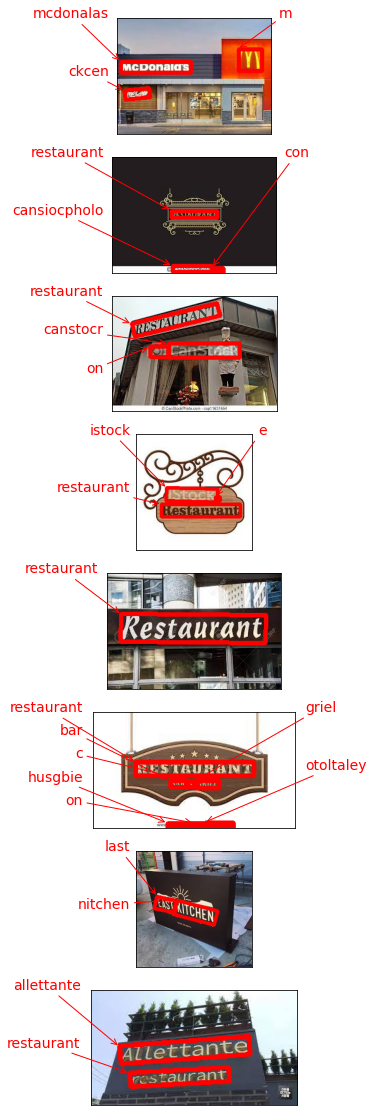

In [27]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesserat OCR


In [46]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

In [47]:
def recognize_images(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")

            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1

    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [48]:
save_dir = os.getenv('HOME')+'/aiffel/data_files/restaurants/'

for restaurant in restaurants:
    print(f'[{restaurant}]')
    try:
        recognize_images(os.path.join(img_dir, restaurant), save_dir)
    except:
        print(f'Cannot recognize characters from {restaurant}')

[big_small_letters.jpg]

Done
[resturant.jpg]
OF. TS F.GS

Q

b

Os in wo a

Done
[small.jpg]
in : mn

Done
[grill.jpg]
Cannot recognize characters from grill.jpg
[big.jpg]
Si

:

Restaurant

Done
[bar.jpg]
a |

l=

23)|

an

Sey

eK wey

rES T

eae

ei Oh ee

“wer shutterstock com - 1476194129

Done
[kitchen.jpg]
Cannot recognize characters from kitchen.jpg
[thick_letters.jpg]
ee us

Done


### Google OCR API

In [49]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [50]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'


# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for restaurant in restaurants:
    print(f'[{restaurant}]')
    detect_text(os.path.join(img_dir, restaurant))
    print()

-rw-r--r-- 1 root root 2321 Nov 27 04:34 /aiffel/aiffel/ocr_python/my_google_api_key.json
[big_small_letters.jpg]
Texts:

"McDonald's
"

"McDonald's"
bounds: (7,75),(120,75),(120,88),(7,88)

[resturant.jpg]
Texts:

"RESTAURANT
© CanStockPhoto.com
"

"RESTAURANT"

"©"

"CanStockPhoto.com"
bounds: (105,178),(176,178),(176,187),(105,187)

[small.jpg]
Texts:

"RESTAURANT
OCanStack
CanStockPhota.com- capt 1631654
"

"RESTAURANT"

"OCanStack"

"CanStockPhota.com-"

"capt"

"1631654"
bounds: (163,180),(185,180),(185,186),(163,186)

[grill.jpg]
Texts:

"Stock.
OC
Restaurant
"

"Stock."

"OC"

"Restaurant"
bounds: (53,133),(202,133),(202,162),(53,162)

[big.jpg]
Texts:

"Restaurant
123RF
"

"Restaurant"

"123RF"
bounds: (239,106),(263,85),(268,91),(244,112)

[bar.jpg]
Texts:

"RESTAURANT
BAR & GRILL
www.shutterstock.com-1476194129
"

"RESTAURANT"

"BAR"

"&"

"GRILL"

"www.shutterstock.com-1476194129"
bounds: (94,162),(202,161),(202,167),(94,168)

[kitchen.jpg]
Texts:

"EAST KITCHEN
-STAURANTAC

### STEP3. 테스트 결과 정리

- 비교하는 함수 만들기

In [53]:
def compare_ocr(restaurant):
    print('[keras-ocr]')
    idx = restaurants.index(restaurant)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    print('[Google OCR]')
    detect_text(os.path.join(img_dir, restaurant))
    print('[Tesseract]')
    recognize_images(os.path.join(img_dir, restaurant), save_dir)

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


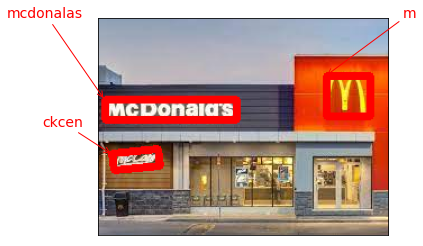

[Google OCR]
Texts:

"McDonald's
"

"McDonald's"
bounds: (7,75),(120,75),(120,88),(7,88)
[Tesseract]

Done


In [54]:
compare_ocr('big_small_letters.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


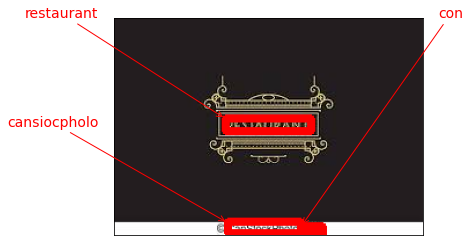

[Google OCR]
Texts:

"RESTAURANT
© CanStockPhoto.com
"

"RESTAURANT"

"©"

"CanStockPhoto.com"
bounds: (105,178),(176,178),(176,187),(105,187)
[Tesseract]
OF. TS F.GS

Q

b

Os in wo a

Done


In [55]:
compare_ocr('resturant.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


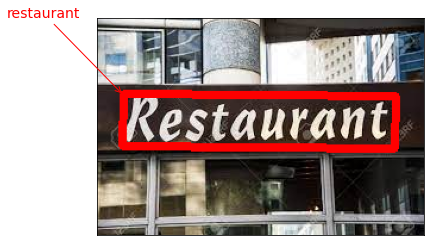

[Google OCR]
Texts:

"Restaurant
123RF
"

"Restaurant"

"123RF"
bounds: (239,106),(263,85),(268,91),(244,112)
[Tesseract]
Si

:

Restaurant

Done


In [56]:
compare_ocr('big.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


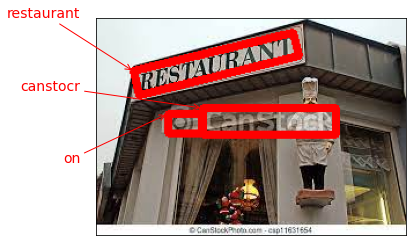

[Google OCR]
Texts:

"RESTAURANT
OCanStack
CanStockPhota.com- capt 1631654
"

"RESTAURANT"

"OCanStack"

"CanStockPhota.com-"

"capt"

"1631654"
bounds: (163,180),(185,180),(185,186),(163,186)
[Tesseract]
in : mn

Done


In [57]:
compare_ocr('small.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


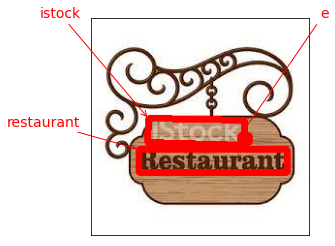

[Google OCR]
Texts:

"Stock.
OC
Restaurant
"

"Stock."

"OC"

"Restaurant"
bounds: (53,133),(202,133),(202,162),(53,162)
[Tesseract]


SystemError: tile cannot extend outside image

In [58]:
compare_ocr('grill.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


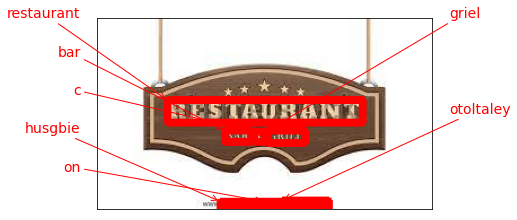

[Google OCR]
Texts:

"RESTAURANT
BAR & GRILL
www.shutterstock.com-1476194129
"

"RESTAURANT"

"BAR"

"&"

"GRILL"

"www.shutterstock.com-1476194129"
bounds: (94,162),(202,161),(202,167),(94,168)
[Tesseract]
a |

l=

23)|

an

Sey

eK wey

rES T

eae

ei Oh ee

“wer shutterstock com - 1476194129

Done


In [59]:
compare_ocr('bar.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


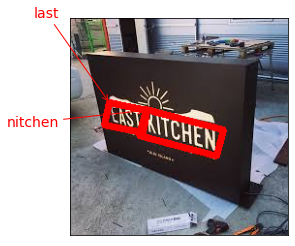

[Google OCR]
Texts:

"EAST KITCHEN
-STAURANTACAFE
"

"EAST"

"KITCHEN"

"-STAURANTACAFE"
bounds: (55,115),(126,136),(124,141),(54,120)
[Tesseract]


SystemError: tile cannot extend outside image

In [60]:
compare_ocr('kitchen.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


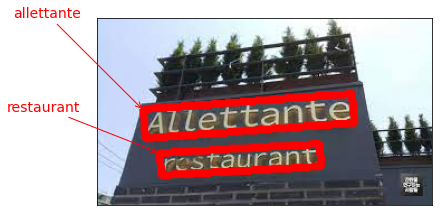

[Google OCR]
Texts:

"Allettante
restaurant
"

"Allettante"

"restaurant"
bounds: (58,123),(196,114),(197,130),(59,139)
[Tesseract]
ee us

Done


In [61]:
compare_ocr('thick_letters.jpg')

### STEP4. 결과 분석 과 결론 제시 

- big_small_letters.jpg: 크고 작은 글씨들이 있고 글자의 간격이 일정하지 않는 경우입니다.

   - 글씨가 큰 mcdoland's는 인식을 잘하는 반면에 글씨도 작고 기울어진 글씨체인 경우에는 인식을 제대로 하지 못했다.
   
   - keras-ocr: 큰 글씨는 정확히 인식했으나 작은 글씨는 그렇지 못함
   
   - 구글 OCR: mcdoland's를 정확히 인식함
   
   - Tesseract: mcdoland's를 정확히 인식함

   - 글자 간격이 일정하지 않을 경우에는 구글OCR > keras-ocr > tesseract순으로 좋다

- resturant.jpg: 심플하게 resturant있는 경우

   - keras-ocr: 큰 글씨는 정확히 인식하지만 역시 작은 글씨는 제대로 인식하지 못함
   
   - 구글OCR: 하나도 빠짐없이 정확히 인식
   
   - Tesseract: 전혀 인식을 하지 못한 것 같다
   

- big.jpg: 더 큰 restaurant가 있는 경우


   - keras-ocr: 큰 글씨는 정확하게 인식했으나 간판에 또다른 작은 글씨는 인식하지 못함
   
   - 구글OCR: 놓친 부분까지 인식함
   
   - Trsseract: 큰 글자는 인식하지만 작은 글자 인식하려다보다 이상한 글씨가 나왔다
   
   - 성능: 구글OCR> Tresseract > keras-ocr
   
   
- small.jpg : 간판과  특이한 글짜가 섞여있는 경우


   - keras-ocr: 눈으로 보이는대로만 읽었다.
   
   - 구글OCR: 큰 글씨 . 흐린 글시 상관없이 다 제대로 읽어냈다
   
   - Tesseract: 아예 인식을 하지 못함
   
   - 성능: 구글OCR> Tresseract > keras-ocr
   
   
- grill.jpg: 문자가 겹쳐있는 경우


   - keras-ocr: 보이는 대로 잘 읽었다
   
   - 구글OCR: 글씨가 겹쳐져있으면 인식의 어려움이 있어보인다.
   
   - Tesseract: 오류가 떴다
   
   - 성능: keras-ocr> 구글OCR> Tresseract 

- bar.jpg: 여러 글씨가 조밀하게 있습니다.

   - keras-ocr: 보이는 대로 인식은 잘하지만 화질이 좋지 않거나 글씨가 작으면 이상하게 인식한다.
   
   - 구글OCR: 특수문자까지 인식을 잘한다
   
   - Tesseract:.. 뭘 인식한지 궁금하다
   
   - 성능: 구글OCR > keras-ocr > tesseract
   


### 회고

- 글씨가 큰 간판의 경우에서는 효과적으로 나타나지만 글씨가 작은 경우에서는 오류가 종종 발생하고 심지어 인식 조차 못하는 경우도 생기는 것으로 보아 외국 여행을 할 때 큰 간판이 있는 가게는 무리없이 잘 찾아갈 수 있을 것 같으니 생각보다는 유용할 것 같습니다.


- 구글OCR의 성능은 놀랍고도 놀랍습니다